Training data: 0-32
Cross Validation data: 33
Test data: 34

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import holidays
#from google.colab import files, drive
from itertools import product
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

In [2]:
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')

Numpy: 1.19.2
Pandas: 1.1.3
Matplotlib: 3.3.2
Seaborn: 0.11.0


In [3]:
# Create new columns with specified time shifts by n months
def feature_lags( df,lags, cols ):
    for col in cols:
        #print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            print('shifted:')
            print(shifted.columns)
            print(shifted.shape)
            
            #print('df:')
            #print(df.columns)
            #print(df.shape)
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [4]:
#drive.mount('/content/drive')

In [5]:
#%cd '/content/drive/My Drive/kaggle/Predict_future_sales'

In [6]:
#copied_path = '/content/drive/My Drive/kaggle/Predict_future_sales/sales_train.csv' 
#sales = pd.read_csv(copied_path)
#copied_path = '/content/drive/My Drive/kaggle/Predict_future_sales/items.csv'
#items = pd.read_csv(copied_path)
#copied_path = '/content/drive/My Drive/kaggle/Predict_future_sales/test.csv'
#test = pd.read_csv(copied_path)
#copied_path = '/content/drive/My Drive/kaggle/Predict_future_sales/item_categories.csv'
#item_category = pd.read_csv(copied_path)
#copied_path = '/content/drive/My Drive/kaggle/Predict_future_sales/shops.csv'
#shop = pd.read_csv(copied_path)

In [7]:
sales = pd.read_csv(r'D:\ML\kaggle\Predict future sales\sales_train.csv')
items = pd.read_csv(r'D:\ML\kaggle\Predict future sales\items.csv')
test = pd.read_csv(r'D:\ML\kaggle\Predict future sales\test.csv')
item_categories = pd.read_csv(r'D:\ML\kaggle\Predict future sales\item_categories.csv')
shops = pd.read_csv(r'D:\ML\kaggle\Predict future sales\shops.csv')

In [8]:
print(sales.shape)
print(sales.dtypes)
print(sales.head())

(2935849, 6)
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


In [9]:
# TEST CODE
#date_item_avg_ check OK: a = sales.loc[(sales['date_block_num'] == 1) & (sales['item_id'] == 32), :]
# item_avg check OK:
a = sales.loc[(sales['date_block_num'] == 0) & (sales['item_id'] == 32), :]
#a = sales.loc[sales['item_id'] == 1480, :]
print(a)
#print('item_cnt_day=', a['item_cnt_day'].sum())
#print('item_price= ', a['item_price'].mean())

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2568    27.01.2013               0       24       32       349.0           1.0
2580    13.01.2013               0       24       32       349.0           1.0
3230    10.01.2013               0       25       32       349.0           1.0
3231    11.01.2013               0       25       32       349.0           2.0
3232    12.01.2013               0       25       32       349.0           3.0
...            ...             ...      ...      ...         ...           ...
115683  21.01.2013               0       46       32       349.0           1.0
115684  11.01.2013               0       46       32       349.0           1.0
115685  19.01.2013               0       46       32       349.0           1.0
115686  18.01.2013               0       46       32       349.0           1.0
115689  07.01.2013               0       46       32       349.0           1.0

[225 rows x 6 columns]


In [10]:
sales.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [11]:
# Merge item_categories from items table to training data (sales dataframe)
sales = pd.merge(sales, items, on ='item_id', how = 'left')
# Confirm that all sales item has a item_category
print(sales.isna().sum())

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64


In [12]:
item_categories.nunique()

item_category_name    84
item_category_id      84
dtype: int64

In [13]:
print(items.shape)
print(items.head())
items.nunique()

(22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  


item_name           22170
item_id             22170
item_category_id       84
dtype: int64

In [16]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [17]:
print(test.shape)
test.head(2)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [18]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [19]:
sales.item_cnt_day.min(), sales.item_cnt_day.max()

(-22.0, 2169.0)

In [20]:
# List the shop IDs with items returned
sales[sales.item_cnt_day < 0]['shop_id'].unique()

array([25, 24, 19, 22, 23, 28, 27, 29, 26,  4,  2,  6, 16, 15, 18,  7, 14,
       12, 31, 30, 32, 35, 56, 54, 59, 53, 47, 50, 42, 43, 52, 38, 44, 41,
       37, 46, 45, 21,  5,  3, 57,  8, 58, 17,  9, 49, 55, 39, 40, 48, 34,
       33, 20, 36], dtype=int64)

<AxesSubplot:xlabel='date_block_num'>

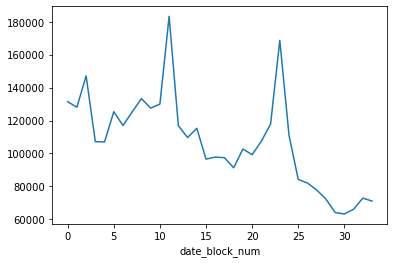

In [21]:
# There are yearly patterns and descending trend according to the chart below.
item_cnt_bymonth = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
item_cnt_bymonth.plot()

      date_block_num  shop_id  item_cnt_day
0                  0        0        5578.0
1                  0        1        2947.0
2                  0        2        1146.0
3                  0        3         767.0
4                  0        4        2114.0
...              ...      ...           ...
1581              33       55        1972.0
1582              33       56        1263.0
1583              33       57        2316.0
1584              33       58        1446.0
1585              33       59         790.0

[1586 rows x 3 columns]


<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_day'>

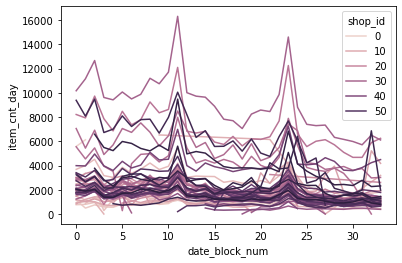

In [22]:
cnt_byshop = sales.groupby(['date_block_num', 'shop_id'], as_index = False)['item_cnt_day'].sum()
print(cnt_byshop)
sns.lineplot(x = 'date_block_num', y = 'item_cnt_day', hue = 'shop_id', data = cnt_byshop)

In [23]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


       item_id  item_price
0            0         NaN
1            1    0.000000
2            2    0.000000
3            3   29.698485
4            4         NaN
...        ...         ...
21802    22165    0.000000
21803    22166    0.000000
21804    22167   12.677302
21805    22168    0.204124
21806    22169         NaN

[21807 rows x 2 columns]


<AxesSubplot:ylabel='item_price'>

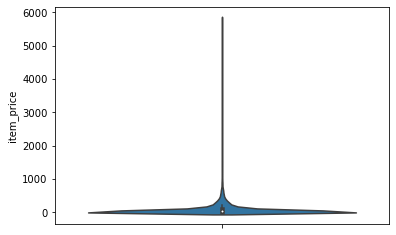

In [24]:
# TBD We want to know if item prices vary on different time and shops for each item_id.
group_price = sales.groupby(['item_id'], as_index = False)['item_price'].std()
#group_price = group_price.loc[group_price.item_id < 10, :]
print(group_price)
sns.violinplot(y = 'item_price', data = group_price)
#sns.lineplot(x = 'date_block_num', y = 'item_id', hue = 'date_block_num', data = group_price)

In [25]:
test['shop_id']

0          5
1          5
2          5
3          5
4          5
          ..
214195    45
214196    45
214197    45
214198    45
214199    45
Name: shop_id, Length: 214200, dtype: int64

Check if there is any shop_id in test set but not in training set. The answer is no.

In [26]:
b = ~test['shop_id'].isin(sales['shop_id'])
print(test.loc[b, 'shop_id'])

Series([], Name: shop_id, dtype: int64)


Check if there is any item_id in test set but not in training set. The answer is Yes!
Therefore, we have to predict using other features such as item_categories, time, shop_id, etc.

In [27]:
print(test.loc[~test['item_id'].isin(sales['item_id'])]['item_id'].unique())

[ 5320  5268  5826  3538  3571  3604  3407  3408  3405  3984  8551  8822
  8823  8824  8890 10779  9767  8355  8354  6729  6731  6732  6152  6153
  6742  7782  7862  6743  6335 13559 13804 13402 14647 14832 14959  2327
  1732  2322  2323  2326  2569  2966 21467 20400 20401 20836  1580  1585
  1246  1437  2328  2427  2325  3022  1193  1252  1386  1884  1885  1577
  3627  4412  3271  3349 13558 13310 13338 12890 13805 13309 12568 13275
 13251 13303 13250 13249 13232 13242 14648 19773 18913 21397 21708 16051
 16141 16193 15553  1284  5269  6730  3338  4060 11974  7728  7729  7926
  8549  8826  5812  5025  9972 11762  7669 13263 13264  8993  7727 18174
 19219  6863 12117 13209 13273 14521  7592  7607  7646  6903  8545  5322
  4156  5843 11385 13271 10028 10203 16139 22022  3760  3908   640   639
   140   249   428 10507 10045 12469 14784 15665 13745 12802 12961  5844
  6996  7730  8191  6734 20403 20560 20378 20878 16976 19155 21828  1864
 20680  3282  3579  2324 12468 13284 13231 17858 16

<AxesSubplot:xlabel='item_cnt_day'>

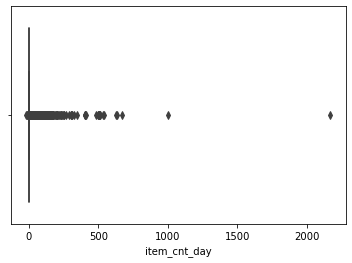

In [28]:
sns.boxplot(x = sales['item_cnt_day'])

In [29]:
# Check rows with item_cnt_day > 1000
sales.loc[sales['item_cnt_day'] >= 1000, :]
# Remove outliers
sales = sales.loc[sales['item_cnt_day'] < 1000, :]

Feature Engineering

In [30]:
# TBD ??? emply???
ru_holidays = holidays.Russia()
print(type(ru_holidays))
print(ru_holidays)

<class 'holidays.countries.russia.Russia'>
{}


In [31]:
# To be removed
#dt = datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S')
#sales['date'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y', dayfirst = True)

# Get the number of days for each month
#sales['year'] = sales['date'].dt.year

In [32]:
sales['year'] = pd.to_datetime(sales['date']).dt.strftime('%Y')
sales['month'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m'))
sales['day'] = sales.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%d'))

sales.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,day
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,01,02
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,2013,01,03


In [33]:
# Calculate the total number of days in each month (i.e. date_block_num) 
tmp = sales.groupby(['date_block_num'])['day'].max()
print(tmp)
tmp = tmp.astype(int)

date_block_num
0     31
1     28
2     31
3     30
4     31
5     30
6     31
7     31
8     30
9     31
10    30
11    31
12    31
13    28
14    31
15    30
16    31
17    30
18    31
19    31
20    30
21    31
22    30
23    31
24    31
25    28
26    31
27    30
28    31
29    30
30    31
31    31
32    30
33    31
Name: day, dtype: object


In [34]:
sales['n_days'] = sales['date_block_num'].map(tmp)
print(sales.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                                  item_name  item_category_id  year month day  \
0                         ЯВЛЕНИЕ 2012 (BD)                37  2013    01  02   
1  DEEP PURPLE  The House Of Blue Light  LP                58  2013    01  03   
2  DEEP PURPLE  The House Of Blue Light  LP                58  2013    01  05   
3  DEEP PURPLE  Who Do You Think We Are  LP                58  2013    01  06   
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56  2013    01  15   

   n_days  
0      31  
1      31  
2      31  
3 

In [35]:
# Convert year, month, day strings to date with datetime64 type 
sales['date'] = sales['year'] +'-'+sales['month']+'-'+sales['day']
sales['date'] = pd.to_datetime(sales['date'])
print(sales['date'].head())
print(sales['date'].dtypes)

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
Name: date, dtype: datetime64[ns]
datetime64[ns]


In [36]:
a = sales['date'].unique()
print(a.shape)
dates = pd.date_range('2013-1-1', '2015-10-31')
print(type(dates))
print(dates)
# It means that all dates appear in training data.

(1034,)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', length=1034, freq='D')


In [37]:
# Create a column with correct date type
print(type(dates))
d = dates.to_frame(index = False, name = 'date')
print(d.columns)
print(d.head())

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index(['date'], dtype='object')
        date
0 2013-01-01
1 2013-01-02
2 2013-01-03
3 2013-01-04
4 2013-01-05


In [38]:
tmp_d = sales[['date_block_num', 'date']]
tr_date = pd.merge(d, tmp_d, on = 'date', how = 'inner')
tr_date.drop_duplicates(inplace = True)
tr_date = tr_date.reset_index(drop = True)

In [39]:
# Create dates for test set
t_date = pd.date_range('2015/11/01', '2015/11/30')
t_date = t_date.to_frame(index = False, name = 'date')
t_date['date_block_num'] = 34
print(t_date)

         date  date_block_num
0  2015-11-01              34
1  2015-11-02              34
2  2015-11-03              34
3  2015-11-04              34
4  2015-11-05              34
5  2015-11-06              34
6  2015-11-07              34
7  2015-11-08              34
8  2015-11-09              34
9  2015-11-10              34
10 2015-11-11              34
11 2015-11-12              34
12 2015-11-13              34
13 2015-11-14              34
14 2015-11-15              34
15 2015-11-16              34
16 2015-11-17              34
17 2015-11-18              34
18 2015-11-19              34
19 2015-11-20              34
20 2015-11-21              34
21 2015-11-22              34
22 2015-11-23              34
23 2015-11-24              34
24 2015-11-25              34
25 2015-11-26              34
26 2015-11-27              34
27 2015-11-28              34
28 2015-11-29              34
29 2015-11-30              34


In [40]:
# Merge training and test date + date_block_num
table = pd.concat([tr_date, t_date], ignore_index = True, axis = 0)
print(table)

           date  date_block_num
0    2013-01-01               0
1    2013-01-02               0
2    2013-01-03               0
3    2013-01-04               0
4    2013-01-05               0
...         ...             ...
1059 2015-11-26              34
1060 2015-11-27              34
1061 2015-11-28              34
1062 2015-11-29              34
1063 2015-11-30              34

[1064 rows x 2 columns]


In [41]:
table['b_weekend'] = table['date'].apply(lambda x: x.weekday() in [5,6])
print(table.head())

        date  date_block_num  b_weekend
0 2013-01-01               0      False
1 2013-01-02               0      False
2 2013-01-03               0      False
3 2013-01-04               0      False
4 2013-01-05               0       True


In [42]:
# Number of weekend days in each month (i.e. 'date_block_num') including the date of test set (2015/11)
n_week = table.groupby(['date_block_num'])['b_weekend'].sum()
print(n_week)

date_block_num
0      8
1      8
2     10
3      8
4      8
5     10
6      8
7      9
8      9
9      8
10     9
11     9
12     8
13     8
14    10
15     8
16     9
17     9
18     8
19    10
20     8
21     8
22    10
23     8
24     9
25     8
26     9
27     8
28    10
29     8
30     8
31    10
32     8
33     9
34     9
Name: b_weekend, dtype: int64


In [43]:
# Create 'city_id' from 'shop_name'
print(shops.loc[shops.shop_id < 10 ,:])
shops['city_id'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_id'] = LabelEncoder().fit_transform(shops['city_id'])
map_shops = shops[['shop_id', 'city_id']]
print(map_shops.head())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
7          Воронеж ТРЦ "Максимир"        7
8    Воронеж ТРЦ Сити-Парк "Град"        8
9               Выездная Торговля        9
   shop_id  city_id
0        0        0
1        1        0
2        2        1
3        3        2
4        4        3


In [44]:
# Create 
print(item_categories.head(100))
item_categories['item_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[0])
print(item_categories['item_type'].isna().sum())

item_categories['item_type'] = LabelEncoder().fit_transform(item_categories['item_type'])
map_item_categories = item_categories[['item_category_id', 'item_type']]
print(map_item_categories.head())

           item_category_name  item_category_id
0     PC - Гарнитуры/Наушники                 0
1            Аксессуары - PS2                 1
2            Аксессуары - PS3                 2
3            Аксессуары - PS4                 3
4            Аксессуары - PSP                 4
..                        ...               ...
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

[84 rows x 2 columns]
0
   item_category_id  item_type
0                 0          0
1                 1          1
2                 2          1
3                 3          1
4                 4          1


In [45]:
# TEST CODE
a = sales.loc[(sales['date_block_num'] == 0) & (sales['shop_id'] == 0) & (sales['item_id'] == 1), :]
#a = sales.loc[sales['item_id'] == 1480, :]
print(a)
#print('item_cnt_day=', a['item_cnt_day'].sum())

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id, year, month, day, n_days]
Index: []


In [46]:
# TBD Each date_block_num should include ALL shop_id + item_id combinations??
# Basis for later model. Create a dataframe with date_block_num, shop_id, and item_id. Each date_block_num has unique shop_id + item_id
col = ['date_block_num', 'shop_id', 'item_id']
train = sales.groupby(col, as_index = False)['item_cnt_day'].sum()
# Column 'item_cnt_day' should be renamed as 'item_cnt_mon'
train = train.rename({'item_cnt_day': 'item_cnt_mon'}, axis = 1)
train['item_cnt_mon'] = train['item_cnt_mon'].fillna(0).clip(0,20)
print(train)

         date_block_num  shop_id  item_id  item_cnt_mon
0                     0        0       32           6.0
1                     0        0       33           3.0
2                     0        0       35           1.0
3                     0        0       43           1.0
4                     0        0       51           2.0
...                 ...      ...      ...           ...
1609118              33       59    22087           6.0
1609119              33       59    22088           2.0
1609120              33       59    22091           1.0
1609121              33       59    22100           1.0
1609122              33       59    22102           1.0

[1609123 rows x 4 columns]


In [47]:
test['date_block_num'] = 34

In [48]:
# Merge training and test set as 'df' dataframe for feature engineering. 
df = pd.concat([train, test.drop(['ID'], axis = 1)], ignore_index = True, sort = False, keys = col)
df.fillna(0, inplace = True)
print(df)

         date_block_num  shop_id  item_id  item_cnt_mon
0                     0        0       32           6.0
1                     0        0       33           3.0
2                     0        0       35           1.0
3                     0        0       43           1.0
4                     0        0       51           2.0
...                 ...      ...      ...           ...
1823318              34       45    18454           0.0
1823319              34       45    16188           0.0
1823320              34       45    15757           0.0
1823321              34       45    19648           0.0
1823322              34       45      969           0.0

[1823323 rows x 4 columns]


In [49]:
# Map number of weekend days to df
df['n_weekends'] = df['date_block_num'].map(n_week)
print(df)

         date_block_num  shop_id  item_id  item_cnt_mon  n_weekends
0                     0        0       32           6.0           8
1                     0        0       33           3.0           8
2                     0        0       35           1.0           8
3                     0        0       43           1.0           8
4                     0        0       51           2.0           8
...                 ...      ...      ...           ...         ...
1823318              34       45    18454           0.0           9
1823319              34       45    16188           0.0           9
1823320              34       45    15757           0.0           9
1823321              34       45    19648           0.0           9
1823322              34       45      969           0.0           9

[1823323 rows x 5 columns]


In [50]:
print(items.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  


In [51]:
# Merge item_category_id to df
tmp = items.drop(['item_name'], axis = 1)
t = tmp.groupby(['item_id'])['item_category_id'].sum()
print(t)
df['item_category_id'] = df['item_id'].map(t)
print(df)

item_id
0        40
1        76
2        40
3        40
4        40
         ..
22165    31
22166    54
22167    49
22168    62
22169    69
Name: item_category_id, Length: 22170, dtype: int64
         date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
0                     0        0       32           6.0           8   
1                     0        0       33           3.0           8   
2                     0        0       35           1.0           8   
3                     0        0       43           1.0           8   
4                     0        0       51           2.0           8   
...                 ...      ...      ...           ...         ...   
1823318              34       45    18454           0.0           9   
1823319              34       45    16188           0.0           9   
1823320              34       45    15757           0.0           9   
1823321              34       45    19648           0.0           9   
1823322              34    

In [52]:
# Merge city_id to df
print(map_shops.columns)
print(df.columns)
df = pd.merge(df, map_shops, on = ['shop_id'], how ='left')
#df.drop(columns = ['city_id_x', 'city_id_y'], inplace = True)
print(df.head())

Index(['shop_id', 'city_id'], dtype='object')
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon', 'n_weekends',
       'item_category_id'],
      dtype='object')
   date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
0               0        0       32           6.0           8   
1               0        0       33           3.0           8   
2               0        0       35           1.0           8   
3               0        0       43           1.0           8   
4               0        0       51           2.0           8   

   item_category_id  city_id  
0                40        0  
1                37        0  
2                40        0  
3                40        0  
4                57        0  


In [53]:
# Merge item_type to df from item_name in items table
df = pd.merge(df, map_item_categories, on = ['item_category_id'], how = 'left')
print(df.head())

   date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
0               0        0       32           6.0           8   
1               0        0       33           3.0           8   
2               0        0       35           1.0           8   
3               0        0       43           1.0           8   
4               0        0       51           2.0           8   

   item_category_id  city_id  item_type  
0                40        0         11  
1                37        0         11  
2                40        0         11  
3                40        0         11  
4                57        0         13  


In [54]:
# Add 'month' column
df['month'] = df['date_block_num'].mod(12)

In [55]:
# Add 'year' column
df['year'] = df['date_block_num'].div(12).astype(int)
df

,date_block_num,shop_id,item_id,item_cnt_mon,n_weekends,item_category_id,city_id,item_type,month,year
0,0,0,32,6.0,8,40,0,11,0,0
1,0,0,33,3.0,8,37,0,11,0,0
2,0,0,35,1.0,8,40,0,11,0,0
3,0,0,43,1.0,8,40,0,11,0,0
4,0,0,51,2.0,8,57,0,13,0,0
...,...,...,...,...,...,...,...,...,...,...
1823318,34,45,18454,0.0,9,55,21,13,10,2
1823319,34,45,16188,0.0,9,64,21,14,10,2
1823320,34,45,15757,0.0,9,55,21,13,10,2
1823321,34,45,19648,0.0,9,40,21,11,10,2


In [56]:
sales.to_csv('sales before_item_price_mean.csv')

In [57]:
# 1. Create item_id vs. average item_price mapping table. 2. Merge (map) the table to training data
col = ['item_id']
t = sales.groupby(col)['item_price'].mean()
print(t)
df['item_avg_item_price'] = df['item_id'].map(t)
print(df.head())

item_id
0          58.000000
1        4490.000000
2          58.000000
3          79.000000
4          58.000000
            ...     
22165      59.000000
22166     150.000000
22167     297.686490
22168     798.916667
22169    4349.000000
Name: item_price, Length: 21807, dtype: float64
   date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
0               0        0       32           6.0           8   
1               0        0       33           3.0           8   
2               0        0       35           1.0           8   
3               0        0       43           1.0           8   
4               0        0       51           2.0           8   

   item_category_id  city_id  item_type  month  year  item_avg_item_price  
0                40        0         11      0     0           249.629240  
1                37        0         11      0     0           252.831928  
2                40        0         11      0     0           375.828056  
3                4

In [58]:
# 1. Create (date_block_num + item_id) vs. average item_price mapping table. 2. Merge the table to training data
cols = ['date_block_num', 'item_id']
t = sales.groupby(cols)['item_price'].mean().to_frame(name = 'date_item_avg_item_price').reset_index()
df = pd.merge(df, t, on = cols, how = 'left')
print(df.head())

   date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
0               0        0       32           6.0           8   
1               0        0       33           3.0           8   
2               0        0       35           1.0           8   
3               0        0       43           1.0           8   
4               0        0       51           2.0           8   

   item_category_id  city_id  item_type  month  year  item_avg_item_price  \
0                40        0         11      0     0           249.629240   
1                37        0         11      0     0           252.831928   
2                40        0         11      0     0           375.828056   
3                40        0         11      0     0           167.222222   
4                57        0         13      0     0           265.708333   

   date_item_avg_item_price  
0                338.110349  
1                488.517241  
2                390.709091  
3                234.50000

In [59]:
df.loc[df['item_id'] == 30, :]

,date_block_num,shop_id,item_id,item_cnt_mon,n_weekends,item_category_id,city_id,item_type,month,year,item_avg_item_price,date_item_avg_item_price
63224,1,0,30,20.0,8,40,0,11,1,0,323.679206,383.921877
65660,1,1,30,10.0,8,40,0,11,1,0,323.679206,383.921877
67731,1,3,30,4.0,8,40,2,11,1,0,323.679206,383.921877
68281,1,4,30,7.0,8,40,3,11,1,0,323.679206,383.921877
69330,1,5,30,5.0,8,40,4,11,1,0,323.679206,383.921877
...,...,...,...,...,...,...,...,...,...,...,...,...
1800410,34,46,30,0.0,9,40,22,11,10,2,323.679206,NaN
1805510,34,41,30,0.0,9,40,19,11,10,2,323.679206,NaN
1810610,34,44,30,0.0,9,40,21,11,10,2,323.679206,NaN
1815710,34,39,30,0.0,9,40,19,11,10,2,323.679206,NaN


In [60]:
print('df:')
print(df.columns)
print(df.shape)

df:
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon', 'n_weekends',
       'item_category_id', 'city_id', 'item_type', 'month', 'year',
       'item_avg_item_price', 'date_item_avg_item_price'],
      dtype='object')
(1823323, 12)


In [61]:
# Create lag features with lags 1, 3, 6, and 12 months
df = feature_lags(df, [1,3, 6, 12], ['item_cnt_mon', 'date_item_avg_item_price'])
print(df.loc[df['date_block_num'] == 1, :])
print(df.shape)

shifted:
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon_lag_1'], dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon_lag_3'], dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon_lag_6'], dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_mon_lag_12'], dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id',
       'date_item_avg_item_price_lag_1'],
      dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id',
       'date_item_avg_item_price_lag_3'],
      dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id',
       'date_item_avg_item_price_lag_6'],
      dtype='object')
(1823323, 4)
shifted:
Index(['date_block_num', 'shop_id', 'item_id',
       'date_item_avg_item_price_lag_12'],
      dtype='object')
(1823323, 4)
        date_block_num  shop_id  i

In [62]:
print(df.loc[df['date_block_num'] == 1, :])
print(df.shape)

        date_block_num  shop_id  item_id  item_cnt_mon  n_weekends  \
63224                1        0       30          20.0           8   
63225                1        0       31          11.0           8   
63226                1        0       32          10.0           8   
63227                1        0       33           3.0           8   
63228                1        0       35          14.0           8   
...                ...      ...      ...           ...         ...   
123154               1       59    22020           2.0           8   
123155               1       59    22024           1.0           8   
123156               1       59    22087           1.0           8   
123157               1       59    22130           2.0           8   
123158               1       59    22134           1.0           8   

        item_category_id  city_id  item_type  month  year  \
63224                 40        0         11      1     0   
63225                 37        0    

In [63]:
print(df.dtypes)

date_block_num                       int64
shop_id                              int64
item_id                              int64
item_cnt_mon                       float64
n_weekends                           int64
item_category_id                     int64
city_id                              int32
item_type                            int32
month                                int64
year                                 int32
item_avg_item_price                float64
date_item_avg_item_price           float64
item_cnt_mon_lag_1                 float64
item_cnt_mon_lag_3                 float64
item_cnt_mon_lag_6                 float64
item_cnt_mon_lag_12                float64
date_item_avg_item_price_lag_1     float64
date_item_avg_item_price_lag_3     float64
date_item_avg_item_price_lag_6     float64
date_item_avg_item_price_lag_12    float64
dtype: object


In [64]:
df.to_csv('cleaned_data.csv')

In [65]:
# TB add revenue feature
#df['revenue'] = df['item_price']*df['item_cnt_day']

In [66]:
df = df[df['date_block_num'] > 11]

In [67]:
print(df.shape)

(1135599, 20)


In [68]:
X_train = df[df['date_block_num'] < 33]
y_train = X_train.item_cnt_mon
X_train = X_train.drop(['item_cnt_mon'], axis = 1)

In [69]:
print(X_train.shape)
print(y_train.shape)

(889868, 19)
(889868,)


In [70]:
X_cv = df[df['date_block_num'] == 33]
y_cv = X_cv.item_cnt_mon
X_cv = X_cv.drop(['item_cnt_mon'], axis = 1)

In [71]:
print(X_cv.shape)
print(y_cv.shape)

(31531, 19)
(31531,)


In [72]:
X_test = df[df['date_block_num'] == 34]
y_test = X_test.item_cnt_mon
X_test = X_test.drop(['item_cnt_mon'], axis = 1)

In [73]:
print(X_test.shape)
print(y_test.shape)

(214200, 19)
(214200,)


In [74]:
model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=300,   
    colsample_bytree=0.8, 
    subsample=0.8, 
    gamma = 0.005,
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_cv, y_cv)], 
    verbose=10, 
    early_stopping_rounds = 40,
    )

[0]	validation_0-rmse:2.77996	validation_1-rmse:2.78967
[10]	validation_0-rmse:2.06942	validation_1-rmse:2.24284
[20]	validation_0-rmse:1.93026	validation_1-rmse:2.13996
[30]	validation_0-rmse:1.88796	validation_1-rmse:2.11733
[40]	validation_0-rmse:1.86670	validation_1-rmse:2.08774
[50]	validation_0-rmse:1.84815	validation_1-rmse:2.07015
[60]	validation_0-rmse:1.83042	validation_1-rmse:2.06015
[70]	validation_0-rmse:1.81722	validation_1-rmse:2.04937
[80]	validation_0-rmse:1.80649	validation_1-rmse:2.04597
[90]	validation_0-rmse:1.79547	validation_1-rmse:2.02449
[100]	validation_0-rmse:1.78422	validation_1-rmse:2.01891
[110]	validation_0-rmse:1.77740	validation_1-rmse:2.01191
[120]	validation_0-rmse:1.77088	validation_1-rmse:2.00035
[130]	validation_0-rmse:1.76256	validation_1-rmse:1.98652
[140]	validation_0-rmse:1.75390	validation_1-rmse:1.98081
[150]	validation_0-rmse:1.74923	validation_1-rmse:1.97789
[160]	validation_0-rmse:1.74242	validation_1-rmse:1.97325
[170]	validation_0-rmse:1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0.005,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)